In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from data.image import CS_Images
from data.config import BRAIN_VISA_PATH, CS_CORRECTED
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

import SimpleITK as sitk

from skimage import measure

import cv2

from utils.fs_mapping import fs_lut

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Loading and plotting data

In [2]:
cs_paths = [x for x in Path(BRAIN_VISA_PATH).glob(CS_CORRECTED)]
dataset = CS_Images(segmentation='all',
                    mesh=True,
                    preload=False)

Found 308 subjects and 308 MPRAGE images
Found 13 subjects with both BrainVisa and corrected from 308 subjects


In [3]:
dataset.get_caseidx('sub-via248')

(array([0]),)

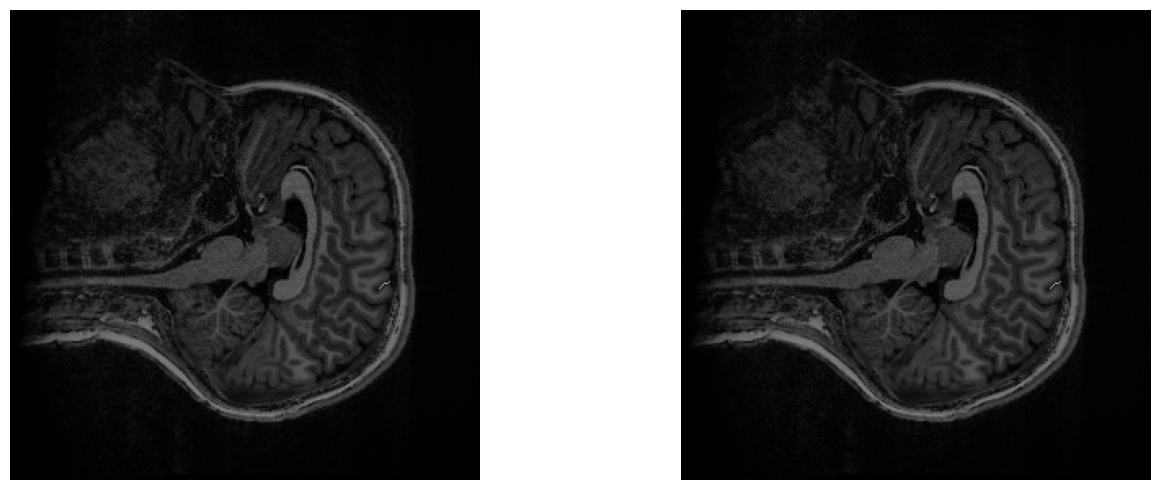

In [4]:
s0 = dataset[2]
img = sitk.GetArrayFromImage(s0['img'])
bvisa = sitk.GetArrayFromImage(s0['bvisa'])
corrected = sitk.GetArrayFromImage(s0['corrected'])
caseid = s0['caseid']
center = s0['centre']
slc = 100

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(img[slc, :, :].T, cmap='gray')
axs[0].imshow(bvisa[slc, :, :].T, alpha=0.5, cmap='gray')
axs[0].set_axis_off()

axs[1].imshow(img[slc, :, :].T, cmap='gray')
axs[1].imshow(corrected[slc, :, :].T, alpha=0.5, cmap='gray')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

In [5]:
def touint8(img):
    return ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)

In [6]:
def img_mask_overlay(img, mask):
    mask = np.stack([mask, mask, mask], axis=-1).astype(np.bool_)
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    img[mask] = 255
    axs.imshow(img)
    axs.set_axis_off()
    plt.show()

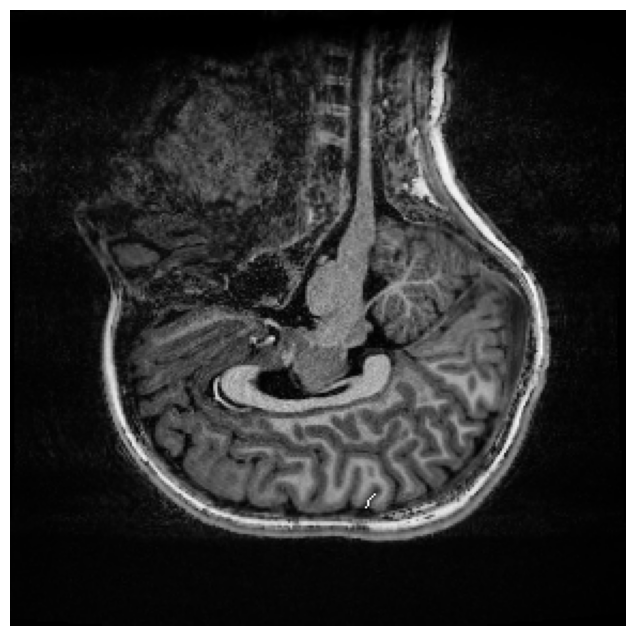

In [7]:
img_rgb = touint8(img[slc, :, :]) # np.stack([img[slc, :, :].T] * 3, axis=-1)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
mask = bvisa[slc, :, :]
img_mask_overlay(img_rgb, mask)

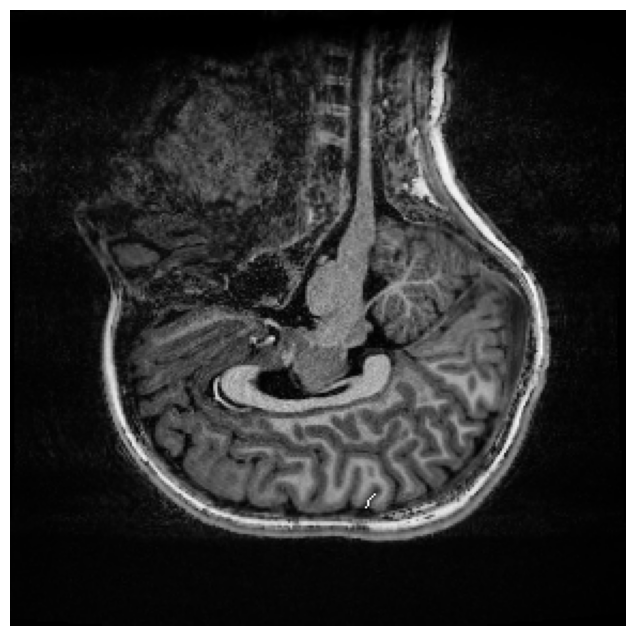

In [8]:
(new_mask, bgModel, fgModel) = cv2.grabCut(img_rgb, (mask!=0).astype(np.uint8), rect=None, bgdModel=None,
                                       fgdModel=None, iterCount=100, mode=cv2.GC_INIT_WITH_MASK)
img_mask_overlay(img_rgb, new_mask)

In [9]:
np.all(((mask !=0) == (new_mask!=0)))

True

In [10]:
caseid

'sub-via227'

## Load Segmentations

In [11]:
import nibabel as nb

In [12]:
segm_path = '/mnt/projects/VIA_Vlad/nobackup/MP2RAGE_FS7_2_0_samseg/via227/mri/samseg/seg.mgz'
segm = nb.load(segm_path)

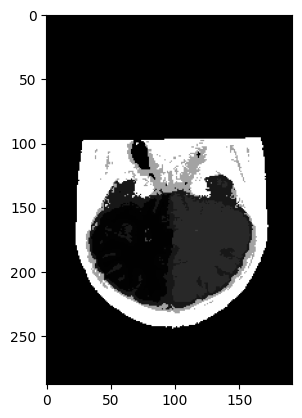

In [13]:
plt.imshow(segm.get_fdata()[slc, :, :], cmap='gray')

In [14]:
segm_array = segm.get_fdata()
np.unique(segm_array)

# 2: left ceribral white matter
# 3: left cerebral cortex
# 41: right cerebral white matter
# 42: right cerebral cortex

array([  0.,   2.,   3.,   4.,   5.,   7.,   8.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  24.,  26.,  28.,  30.,  31.,  41.,
        42.,  43.,  44.,  46.,  47.,  49.,  50.,  51.,  52.,  53.,  54.,
        58.,  60.,  62.,  63.,  77.,  80.,  85., 165., 258., 259.])

In [15]:
reg_params = '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/BrainVisa/CFIN/sub-via227/t1mri/default_acquisition/registration/RawT1-sub-via227_default_acquisition_TO_Talairach-MNI.trm'

```
Tx Ty Tz
Rxx Rxy Rxz
Ryx Ryy Ryz
Rzx Rzy Rzz
```
With `R1_TO_R2.trm` meaning that the given tranformation matrix moves from R1 to R2 (aka `x2 = R*X1 + T`)

In [16]:
with open(reg_params, 'r') as f:
    transf_matrix = [[float(y.strip()) for y in x.split(' ')] for x in f.readlines()]

In [17]:
transf_matrix

[[86.3141, 115.605, 118.533],
 [-0.999999, -0.00172322, -1.08668e-05],
 [0.00172324, -0.999949, -0.00998452],
 [-6.33922e-06, 0.00998452, -0.99995]]

In [18]:
def transform_affine(image:sitk.Image, affmatrix:np.ndarray, interpolator=sitk.sitkBSpline):
    """Transform image with a given affine matrix

    Args:
        image (sitk.Image): Image to transform
        affmatrix (np.ndarray): Affine matrix of shape (4, 3) with the following format:
            Tx  Ty  Tz
            Rxx Rxy Rxz
            Ryx Ryy Ryz
            Rzx Rzy Rzz
        interpolator (_type_, optional): _description_. Defaults to sitk.sitkBSpline.

    Returns:
        _type_: _description_
    """
    reference_image = image
    tx, ty, tz = transf_matrix[0]
    rot00, rot01, rot02 = transf_matrix[1]
    rot10, rot11, rot12 = transf_matrix[2]
    rot20, rot21, rot22 = transf_matrix[3]
    # center = [0, 0, 0]

    sitk_aff_matrix = [rot00, rot01, rot02, rot10, rot11, rot12, rot20, rot21, rot22]
    transl_vector = [tx, ty, tz]
    # 3D affine transform
    transform = sitk.AffineTransform(3)
    
    # transform.SetMatrix(sitk_aff_matrix)
    transform.SetTranslation(transl_vector)
    # transform.SetCenter(center)
    
    return sitk.Resample(image, reference_image, transform, interpolator)

In [19]:
plt.imshow(orig_transformed_array[slc, :, :].T, cmap='gray')

NameError: name 'orig_transformed_array' is not defined

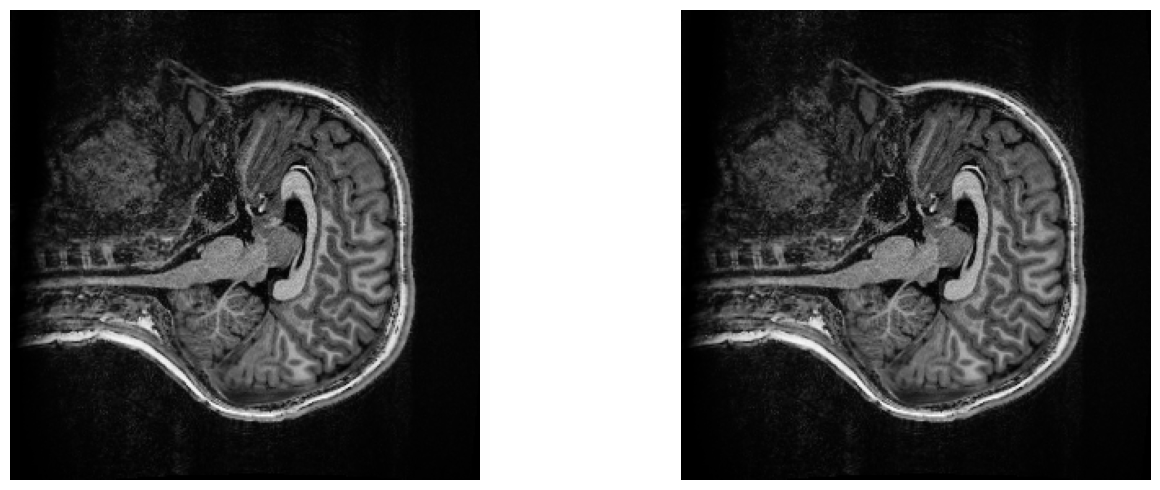

In [ ]:
orig_img = sitk.ReadImage('/mnt/projects/VIA_Vlad/nobackup/mp2rage/CFIN/sub-via227_ses-01CFINskyra_acq-mp2rage_rec-nomoco_run-01_Robust.nii.gz')
orig_transformed = transform_affine(orig_img, transf_matrix)
orig_transformed_array = sitk.GetArrayFromImage(orig_img)
slc = 100

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(img[slc, :, :].T, cmap='gray')
axs[0].set_axis_off()

axs[1].imshow(orig_transformed_array[slc, :, :].T, cmap='gray')
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

Samseg segmentation labels
```
2: left ceribral white matter
3: left cerebral cortex
41: right cerebral white matter
42: right cerebral cortex
165: skull
24: csf
````

In [20]:
labels = [segm_array.T[bvisa!=0]]
np.unique(labels, return_counts=True)

(array([  3.,  24.,  42., 165., 258.]), array([ 639, 2427,  618,  188,   56]))

In [21]:
from data.segmentation_properties import SegmAnalyzer
seg_analyzer = SegmAnalyzer()

In [22]:
bvisa = s0['bvisa']

In [24]:
i = 2

segm_properties = seg_analyzer.process(bvisa, caseid)
segm_properties

{'LCS_lebel2inters': {3: 639, 24: 1164, 165: 106, 258: 53},
 'RCS_lebel2inters': {24: 1263, 42: 618, 165: 82, 258: 3}}

In [81]:
ls = s0['bvisa_mesh_lscl']
ls.compute_triangle_normals()

TriangleMesh with 2534 points and 5068 triangles.

In [83]:
np.asarray(ls.triangle_normals)

array([[ 0.19592778,  0.48811068, -0.85050589],
       [ 0.21491782,  0.4262786 , -0.87869044],
       [ 0.42986026,  0.90240214, -0.0298419 ],
       ...,
       [-0.55397402, -0.43921096,  0.7072528 ],
       [-0.65256454,  0.15301489,  0.74212261],
       [-0.47323516, -0.16706986,  0.86494864]])

## Branching statistics

{3: 639, 24: 2427, 42: 618, 165: 188, 258: 56}

In [21]:
s0 = dataset[1]
img = sitk.GetArrayFromImage(s0['img'])
bvisa = sitk.GetArrayFromImage(s0['bvisa'])
corrected = sitk.GetArrayFromImage(s0['corrected'])
caseid = s0['caseid']
center = s0['centre']


diff_image = bvisa != corrected

3

In [41]:
labels = measure.label(bvisa,
                       connectivity=2,
                       background=0)

In [42]:
np.unique(labels)

array([0, 1, 2, 3])

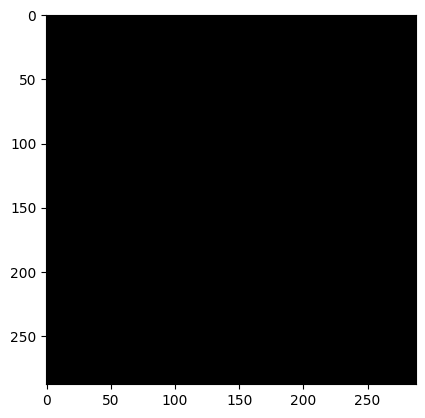

In [20]:
plt.imshow(diff_image[slc, :, :].T, cmap='gray')

In [19]:
from tqdm import tqdm
from data.mesh import MeshAnalyzer

In [20]:
a = s0['bvisa_mesh_lscl']

In [27]:
mesh_analyzer = MeshAnalyzer(['mesh_properties',
                              'cluster_properties',
                              'holes_filled_volume'])
mesh_analyzer.process(a)

[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'


{'is_self_intersecting': False,
 'is_watertight': True,
 'is_edge_manifold': True,
 'is_vertex_manifold': True,
 'cluster_connected_triangles': 4948,
 'triangl_per_clust': [4948],
 'srf_are_per_clust': DoubleVector[3623.36],
 'total_srf_area': 3623.359676571132,
 'total_volume': 1312.6516921477614,
 'filled_volume': 1312.651692147765}

## Load the analysis results